In [1]:
import os

# Basic data manipulation
import pandas as pd
import numpy as np

import statsmodels

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Enchancement
from termcolor import colored
from IPython.display import display

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

# Model evaluation
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

# Global variables:
target = 'SalePrice'
train_path = '../data/house-prices/train.csv'
test_path = '../data/house-prices/test.csv'
submission_path = '../data/house-prices/submission.csv'

# Configs
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
%matplotlib inline


#import os
#os.chdir('data-science-notes')
#os.getcwd()
    
print('Setup complete.')

Setup complete.


In [2]:
# Loading data:
print(colored(f'pwd: ' + os.getcwd(), color='magenta'))
train_full = pd.read_csv(train_path)
X_test_full  = pd.read_csv(test_path)

#Save the 'Id' column
train_ID = train_full['Id']
test_ID = X_test_full['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train_full.drop("Id", axis = 1, inplace = True)
X_test_full.drop("Id", axis = 1, inplace = True)

train_full.rename(columns={'3SsnPorch':'TSsnPorch'}, inplace=True)
X_test_full.rename(columns={'3SsnPorch':'TSsnPorch'}, inplace=True)

train_full.dropna(axis=0, subset=[target], inplace=True)

# Dropping the Target column
y = train_full[target]
X_full = train_full.drop([target], axis=1, inplace=False)

#disdescribey(data_train.head())
print(colored(f"Train data columns", color = 'blue', attrs= ['dark', 'bold']))
print(colored(train_full.columns, color = 'green'))
print(colored('%d columns' % train_full.columns.size, color = 'red', attrs= ['dark', 'bold']))
print(colored(train_full.dtypes.value_counts(), color = 'red'))

pwd: D:\Users\jader\proj\data_science\data-science-notes\jupyter-notebooks
Train data columns
Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'G

## Exploratory Data Analysis (EDA)
### Take a First Look of our Data:
The function below is inspired on the str function of R, this function returns the information about
the train data set. Most of them are self-explanatory, but some are worth mentioning:

- **corr**: Only available for Supervised Learning is the correlation beetween the variable and the target.
- **skewness**: It's a measure of assymetry of the variable distribuition.
- **kurtosis**: It's also a shape measure of distribuition related with the tail. Higher kurtosis corresponds to greater extremity of deviations (or outliers).

In [3]:
def describe(df, pred=None): 
    size = df.shape[0]
    numerical_cols = [col for col in df.columns if
                      df[col].dtype in ['int64', 'float64']]

    # Series
    types = df.dtypes.rename('types')
    counts = df.apply(lambda x: x.count()).rename('counts')
    uniques = df.apply(lambda x: [x.unique()]).transpose()[0].rename('unique')
    nulls = df.apply(lambda x: x.isnull().sum()).rename('nulls')
    distincts = df.apply(lambda x: x.unique().shape[0]).rename('distincts')
    missing_ration = ((df.isnull().sum() / size) * 100).rename('missing_ration')
    skewness = df[numerical_cols].skew().rename('skewness')
    kurtosis = df[numerical_cols].kurt().rename('kurtosis')

    if target is None:
        result = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis], axis = 1)
    else:
        corr = df.corr()[target].rename('corr')
        result = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis, corr], axis = 1, sort=False)

    print('___________________________')
    print('Data shape:', df.shape)
    print(colored(f"Train data columns", color = 'blue', attrs= ['dark', 'bold']))
    print(colored(df.columns, color = 'green'))
    print(colored('%d columns' % df.columns.size, color = 'red', attrs= ['dark', 'bold']))
    print(colored(df.dtypes.value_counts(), color = 'red'))
    print('___________________________')

    return result

In [4]:
details = describe(train_full, target)
display(details.sort_values(by='corr', ascending=False))

details_missing = details[details.missing_ration != 0]
print(colored("Missing Ration is non null in %d columns." % details_missing.shape[0], color="blue", attrs=["bold"]))
display(details_missing.sort_values(by='missing_ration', ascending=False)[['counts','missing_ration']])

___________________________
Data shape: (1460, 80)
Train data columns
Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCar

,types,counts,distincts,nulls,missing_ration,unique,skewness,kurtosis,corr
SalePrice,int64,1460,663,0,0.000,"[208500, 181500, 223500, 140000, 250000, 14300...",1.883,6.536,1.000
OverallQual,int64,1460,10,0,0.000,"[7, 6, 8, 5, 9, 4, 10, 3, 1, 2]",0.217,0.096,0.791
GrLivArea,int64,1460,861,0,0.000,"[1710, 1262, 1786, 1717, 2198, 1362, 1694, 209...",1.367,4.895,0.709
GarageCars,int64,1460,5,0,0.000,"[2, 3, 1, 0, 4]",-0.343,0.221,0.640
GarageArea,int64,1460,441,0,0.000,"[548, 460, 608, 642, 836, 480, 636, 484, 468, ...",0.180,0.917,0.623
...,...,...,...,...,...,...,...,...,...
PoolQC,object,7,4,1453,99.521,"[nan, Ex, Fa, Gd]",NaN,NaN,NaN
Fence,object,281,5,1179,80.753,"[nan, MnPrv, GdWo, GdPrv, MnWw]",NaN,NaN,NaN
MiscFeature,object,54,5,1406,96.301,"[nan, Shed, Gar2, Othr, TenC]",NaN,NaN,NaN
SaleType,object,1460,9,0,0.000,"[WD, New, COD, ConLD, ConLI, CWD, ConLw, Con, ...",NaN,NaN,NaN


Missing Ration is non null in 19 columns.


,counts,missing_ration
PoolQC,7,99.521
MiscFeature,54,96.301
Alley,91,93.767
Fence,281,80.753
FireplaceQu,770,47.260
LotFrontage,1201,17.740
GarageType,1379,5.548
GarageYrBlt,1379,5.548
GarageFinish,1379,5.548
GarageQual,1379,5.548


## Observations about Details

- The **SalePrice** variable is **skewed** and **heavy-tailed distribuition**. We need investigate how to correct it. First we can try a transformation by **Log 1P** without drop most of outliers.

- About **Missing** and **Null** values, we can see *19* columns with missing values, where *5* of them has a missing rating greater than *47%*.
    - **PoolQC:** Pool Quality, we can check PoolArea and if it's 0 we know that the *null* value here should be the **NA** categorical value.
    - **MiscFeature:** Features that are not covered in other variables like a presence of *Elevator*. Probably when is not mentioned the value should be also **NA**.
    - **Alley:** Type of alley access to the property.
    - **Fence:** Fence Quality, no fence should be **NA**.
    - **FireplaceQu:** Fireplace Quality. If the row has a null value here we can check if the number of fireplaces (stored on Fireplaces variable) is *0*. In this case, quality should be **NA**.


- Features **high-skewess**, **heavely-tailed** and with **high correlation** to SalesPrice. It is important to treat them (boxcox 1p transformation, Robustscaler, and drop some outliers):
    - TotalBsmtSF
    - 1stFlrSF
    - GrLivArea 


- Features **high-skewed**, **heavy-tailed** distribution, and with **low correlation** to Sales Price. Maybe we can drop these features, or just use they with other to create a new more importants feature:
    - MiscVal
    - TSsnPorch
    - LowQualFinSF
    - BsmtFinSF2
    - BsmtHalfBa


- Features **high-skewness**, **heavy-tailed** distribution, and with **good correlation** to Sales Price. It is important to treat them (boxcox 1p transformation, Robustscaler, and drop some outliers):
    - PoolArea
    - LotArea
    - KitchenAbvGr
    - ScreenPorch
    - EnclosedPorch
    - MasVnrArea
    - OpenPorchSF
    - LotFrontage
    - BsmtFinSF1
    - WoodDeckSF
    - MSSubClass


- Features **not high skewed**, and with **not high correlation** to Sales Price. Just use a Robustscaler probably reduce the few distorcions:
    - BsmtUnfSF
    - 2ndFlrSF
    - TotRmsAbvGrd
    - HalfBath
    - Fireplaces
    - BsmtFullBath
    - OverallQual
    - BedroomAbvGr
    - GarageArea
    - FullBath
    - GarageCars
    - OverallCond


- Transforme from Yaer Feature to Age, 2011 - Year feature, or YEAR(TODAY()) - Year Feature
    - YearRemodAdd
    - YearBuilt
    - GarageYrBlt
    - YrSold



#### Check some simple facts about the observations above

In [5]:
########################
print(colored("PoolQC null => PoolArea = 0", color="green", attrs=["bold"]))
display(train_full[train_full.PoolQC.isna()]['PoolArea'].value_counts())
print('\n')

########################
print(colored("FireplaceQu null => Fireplaces = 0", color="green", attrs=["bold"]))
display(train_full[train_full.FireplaceQu.isna()]['Fireplaces'].value_counts())
print('\n')

# MASKS DEFINITION
def lgh_masks(feat, low, high):
    feat_abs = np.abs(details[feat])
    
    return (
         feat_abs <= low,
         (feat_abs > low) * (feat_abs < high),
         feat_abs >= high
    )

(lcorr_mask, gcorr_mask, hcorr_mask) = lgh_masks('corr', 0.05, 0.5)
(lskew_mask, gskew_mask, hskew_mask) = lgh_masks('skewness', 0.5, 1)
(lkurt_mask, gkurt_mask, hkurt_mask) = lgh_masks('kurtosis', 0.5, 1.5)

########################
removed_feats = ['SalePrice', 'YearRemodAdd', 'YearBuilt', 'GarageYrBlt', 'YrSold'] 

print(colored("high-skewness + high-tailed + high corr", color="blue", attrs=["bold"]))
mask = (~details.index.isin(removed_feats)) & \
       (~details['skewness'].isna()) & \
       hskew_mask & hkurt_mask & hcorr_mask
display(details[mask].sort_values(by=['skewness', 'kurtosis'], ascending=False))

########################
print(colored("high-skewness + high-tailed + low corr", color="red", attrs=["bold"]))
mask = (~details.index.isin(removed_feats)) & \
       (~details['skewness'].isna()) & \
       hskew_mask & hkurt_mask & lcorr_mask
display(details[mask].sort_values(by=['skewness', 'kurtosis'], ascending=False))

########################
print(colored("high-skewness + high-tailed + good corr", color="yellow", attrs=["bold"]))
mask = (~details.index.isin(removed_feats)) & \
       (~details['skewness'].isna()) & \
        hskew_mask & hkurt_mask & gcorr_mask
display(details[mask].sort_values(by=['skewness', 'kurtosis'], ascending=False))

########################
print(colored("low|good skewness + good|high corr", color="blue", attrs=["bold"]))
mask = (~details.index.isin(removed_feats)) & \
       (~details['skewness'].isna()) & \
       (~hskew_mask) & (~lcorr_mask)
display(details[mask].sort_values(by=['skewness', 'kurtosis'], ascending=False))

PoolQC null => PoolArea = 0


0    1453
Name: PoolArea, dtype: int64



FireplaceQu null => Fireplaces = 0


0    690
Name: Fireplaces, dtype: int64



high-skewness + high-tailed + high corr


,types,counts,distincts,nulls,missing_ration,unique,skewness,kurtosis,corr
TotalBsmtSF,int64,1460,721,0,0.000,"[856, 1262, 920, 756, 1145, 796, 1686, 1107, 9...",1.524,13.250,0.614
1stFlrSF,int64,1460,753,0,0.000,"[856, 1262, 920, 961, 1145, 796, 1694, 1107, 1...",1.377,5.746,0.606
GrLivArea,int64,1460,861,0,0.000,"[1710, 1262, 1786, 1717, 2198, 1362, 1694, 209...",1.367,4.895,0.709


high-skewness + high-tailed + low corr


,types,counts,distincts,nulls,missing_ration,unique,skewness,kurtosis,corr
MiscVal,int64,1460,21,0,0.000,"[0, 700, 350, 500, 400, 480, 450, 15500, 1200,...",24.477,701.003,-0.021
TSsnPorch,int64,1460,20,0,0.000,"[0, 320, 407, 130, 180, 168, 140, 508, 238, 24...",10.304,123.662,0.045
LowQualFinSF,int64,1460,24,0,0.000,"[0, 360, 513, 234, 528, 572, 144, 392, 371, 39...",9.011,83.235,-0.026
BsmtFinSF2,int64,1460,144,0,0.000,"[0, 32, 668, 486, 93, 491, 506, 712, 362, 41, ...",4.255,20.113,-0.011
BsmtHalfBath,int64,1460,3,0,0.000,"[0, 1, 2]",4.103,16.397,-0.017


high-skewness + high-tailed + good corr


,types,counts,distincts,nulls,missing_ration,unique,skewness,kurtosis,corr
PoolArea,int64,1460,8,0,0.000,"[0, 512, 648, 576, 555, 480, 519, 738]",14.828,223.268,0.092
LotArea,int64,1460,1073,0,0.000,"[8450, 9600, 11250, 9550, 14260, 14115, 10084,...",12.208,203.243,0.264
KitchenAbvGr,int64,1460,4,0,0.000,"[1, 2, 3, 0]",4.488,21.532,-0.136
ScreenPorch,int64,1460,76,0,0.000,"[0, 176, 198, 291, 252, 99, 184, 168, 130, 142...",4.122,18.439,0.111
EnclosedPorch,int64,1460,120,0,0.000,"[0, 272, 228, 205, 176, 87, 172, 102, 37, 144,...",3.090,10.431,-0.129
MasVnrArea,float64,1452,328,8,0.548,"[196.0, 0.0, 162.0, 350.0, 186.0, 240.0, 286.0...",2.669,10.082,0.477
OpenPorchSF,int64,1460,202,0,0.000,"[61, 0, 42, 35, 84, 30, 57, 204, 4, 21, 33, 21...",2.364,8.490,0.316
LotFrontage,float64,1201,111,259,17.740,"[65.0, 80.0, 68.0, 60.0, 84.0, 85.0, 75.0, nan...",2.164,17.453,0.352
BsmtFinSF1,int64,1460,637,0,0.000,"[706, 978, 486, 216, 655, 732, 1369, 859, 0, 8...",1.686,11.118,0.386
WoodDeckSF,int64,1460,274,0,0.000,"[0, 298, 192, 40, 255, 235, 90, 147, 140, 160,...",1.541,2.993,0.324


low|good skewness + good|high corr


,types,counts,distincts,nulls,missing_ration,unique,skewness,kurtosis,corr
BsmtUnfSF,int64,1460,780,0,0.000,"[150, 284, 434, 540, 490, 64, 317, 216, 952, 1...",0.920,0.475,0.214
2ndFlrSF,int64,1460,417,0,0.000,"[854, 0, 866, 756, 1053, 566, 983, 752, 1142, ...",0.813,-0.553,0.319
OverallCond,int64,1460,9,0,0.000,"[5, 8, 6, 7, 4, 2, 3, 9, 1]",0.693,1.106,-0.078
TotRmsAbvGrd,int64,1460,12,0,0.000,"[8, 6, 7, 9, 5, 11, 4, 10, 12, 3, 2, 14]",0.676,0.881,0.534
HalfBath,int64,1460,3,0,0.000,"[1, 0, 2]",0.676,-1.077,0.284
Fireplaces,int64,1460,4,0,0.000,"[0, 1, 2, 3]",0.650,-0.217,0.467
BsmtFullBath,int64,1460,4,0,0.000,"[1, 0, 2, 3]",0.596,-0.839,0.227
OverallQual,int64,1460,10,0,0.000,"[7, 6, 8, 5, 9, 4, 10, 3, 1, 2]",0.217,0.096,0.791
BedroomAbvGr,int64,1460,8,0,0.000,"[3, 4, 1, 2, 0, 5, 6, 8]",0.212,2.231,0.168
GarageArea,int64,1460,441,0,0.000,"[548, 460, 608, 642, 836, 480, 636, 484, 468, ...",0.180,0.917,0.623


### Let's look for numeric data stats

In [6]:
display(train_full.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.000,56.897,42.301,20.000,20.000,50.000,70.000,190.000
LotFrontage,1201.000,70.050,24.285,21.000,59.000,69.000,80.000,313.000
LotArea,1460.000,10516.828,9981.265,1300.000,7553.500,9478.500,11601.500,215245.000
OverallQual,1460.000,6.099,1.383,1.000,5.000,6.000,7.000,10.000
OverallCond,1460.000,5.575,1.113,1.000,5.000,5.000,6.000,9.000
YearBuilt,1460.000,1971.268,30.203,1872.000,1954.000,1973.000,2000.000,2010.000
YearRemodAdd,1460.000,1984.866,20.645,1950.000,1967.000,1994.000,2004.000,2010.000
MasVnrArea,1452.000,103.685,181.066,0.000,0.000,0.000,166.000,1600.000
BsmtFinSF1,1460.000,443.640,456.098,0.000,0.000,383.500,712.250,5644.000
BsmtFinSF2,1460.000,46.549,161.319,0.000,0.000,0.000,0.000,1474.000


### Variable: OverallQual (Overall Quality)
Overall Quality has the highest correlation with SalePrice among all numeric variables (*0.791*).
The *data description* provided say that this column rates the overall material and finish of the house using
an integer rate from 1 (very poor) to 10 (very excelent).

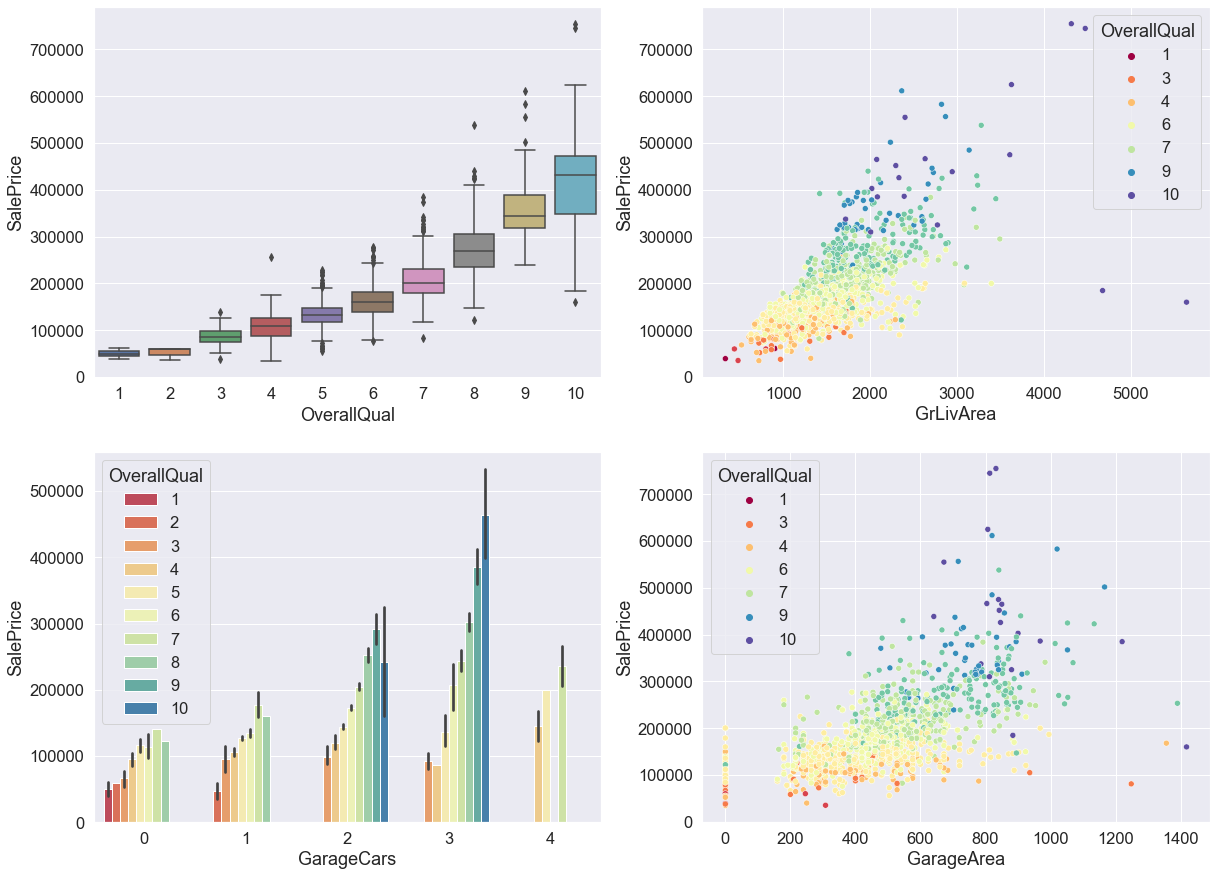

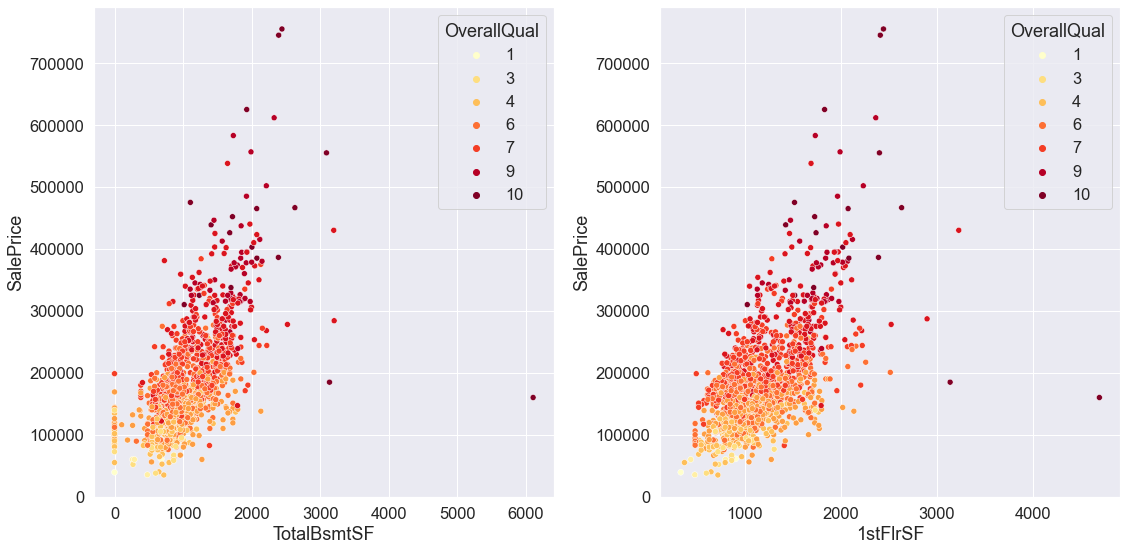

In [7]:
fig = plt.figure(figsize=(20, 15))
sns.set(font_scale=1.5)

# Box plot overallqual/salePrice
fig1 = fig.add_subplot(221)
sns.boxplot(x='OverallQual', y='SalePrice', data=train_full[['SalePrice', 'OverallQual']])

# GrLivArea vs SalePrice plot
fig2 = fig.add_subplot(222); 
sns.scatterplot(x=train_full.GrLivArea, y=train_full.SalePrice, hue=train_full.OverallQual, palette='Spectral')

# GarageCars vs SalePrice plot
fig3 = fig.add_subplot(223); 
sns.barplot(x=train_full.GarageCars, y=train_full.SalePrice, hue=train_full.OverallQual, palette='Spectral')

# GarageArea vs SalePrice plot
fig4 = fig.add_subplot(224); 
sns.scatterplot(x=train_full.GarageArea, y=train_full.SalePrice, hue=train_full.OverallQual, palette='Spectral')

# TotalBsmtSF (hue OverallQual) vs SalePrice
fig5 = plt.figure(figsize=(16, 8))
fig6 = fig5.add_subplot(121); 
sns.scatterplot(y=train_full.SalePrice , x=train_full.TotalBsmtSF, hue=train_full.OverallQual, palette= 'YlOrRd')

# TotalBsmtSF (hue OverallQual) vs SalePrice
fig7 = fig5.add_subplot(122); 
sns.scatterplot(y=train_full.SalePrice, x=train_full['1stFlrSF'], hue=train_full.OverallQual, palette= 'YlOrRd')

plt.tight_layout()
plt.show()

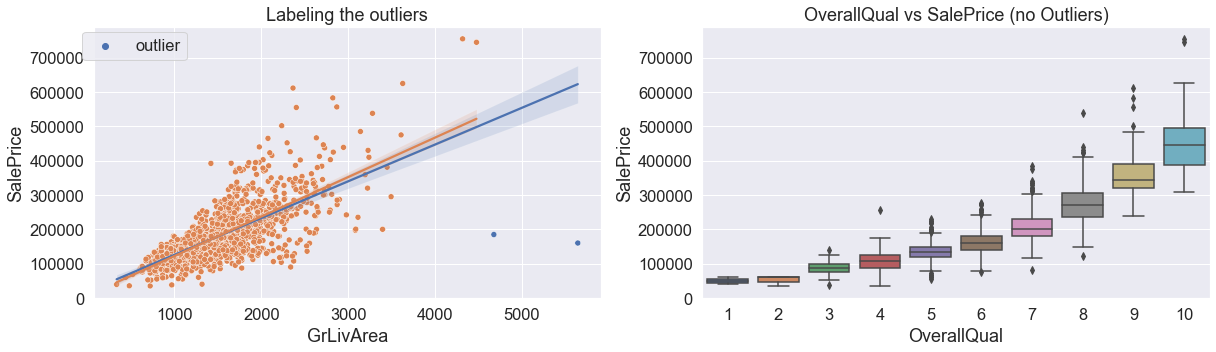

In [8]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(121)

# outliers was obtained just looking the plot
# after that, I create this following bool series and labeled the dots.
# Also, we can see in the above plot, that these two outliers are extremely
# low priced for an OverallQuality 10.
outliers = (train_full.GrLivArea>4000) & (train_full.SalePrice<300000)

sns.scatterplot(x=train_full.GrLivArea, y=train_full.SalePrice, hue=~outliers, ax=ax1)
sns.regplot(x='GrLivArea', y='SalePrice', scatter=False, data=train_full, ax=ax1)
sns.regplot(x='GrLivArea', y='SalePrice', scatter=False, data=train_full[~outliers], ax=ax1)

legend_labels, _= ax1.get_legend_handles_labels()
ax1.legend(legend_labels, ['outlier'], title='', bbox_to_anchor=(0.2,1.01))
ax1.set_title('Labeling the outliers')

# Check the overallqual again
ax2 = fig.add_subplot(122)
sns.boxplot(x=train_full[~outliers].OverallQual, y=train_full[~outliers].SalePrice, ax=ax2)
ax2.set_title('OverallQual vs SalePrice (no Outliers)')

plt.show()

### Total Rooms above Ground and Living Area
It's natural to ask if the total rooms above ground (TotRmsAbvGrd) and the living area above ground (GrLivArea)
can produce a better predictor. Here we investigate the *average area of a room* and their product and study the
correlation with SalePrice.

corr GrLiv:  0.7349681645359328
corr TotRms:  0.5377688162416006
                                                             Outliers: 1


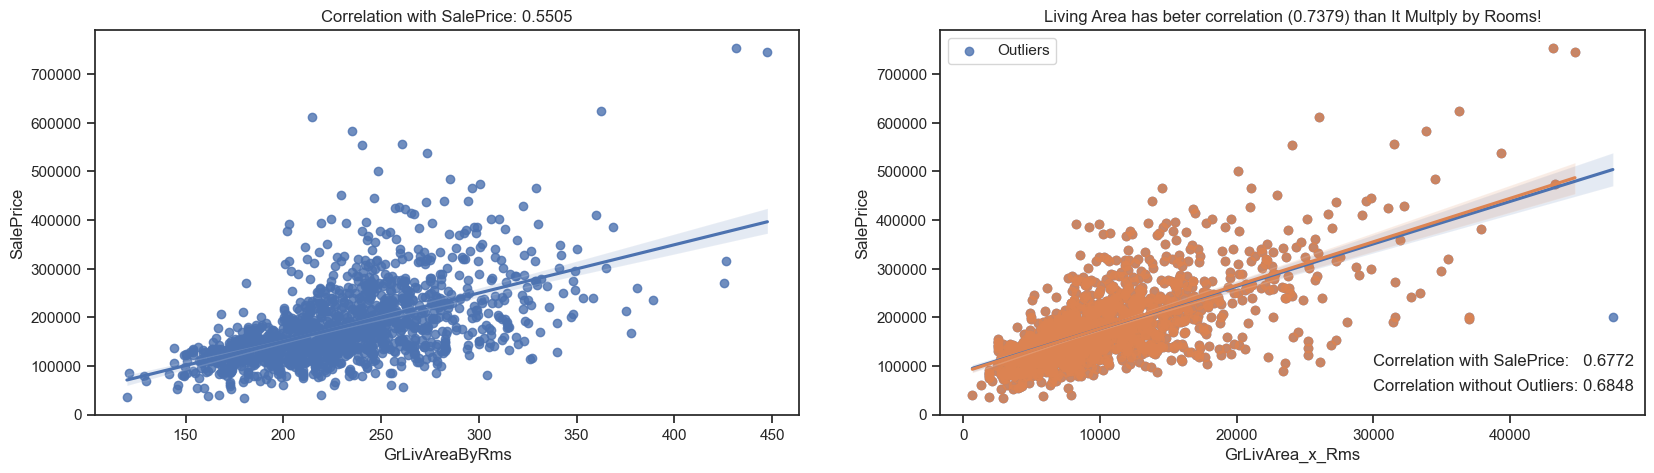

In [9]:
sns.reset_defaults()
sns.set(style="ticks", color_codes=True)

# Removing previous outliers
train = train_full[~outliers]

df = train[['SalePrice', 'GrLivArea', 'TotRmsAbvGrd']].copy()
df['GrLivAreaByRms'] = train.GrLivArea/train.TotRmsAbvGrd
df['GrLivArea_x_Rms'] = train.GrLivArea*train.TotRmsAbvGrd

corr_GrLiv_x_Rms = df.GrLivArea_x_Rms.corr(df['SalePrice'])
corr_GrLivByRms = df.GrLivAreaByRms.corr(df['SalePrice'])
corr_GrLiv = df.GrLivArea.corr(df['SalePrice'])
corr_TotRms = df.TotRmsAbvGrd.corr(df['SalePrice'])
print('corr GrLiv: ', corr_GrLiv)
print('corr TotRms: ', corr_TotRms)

fig = plt.figure(figsize=(20,5))
fig1 = fig.add_subplot(121); sns.regplot(x='GrLivAreaByRms', y='SalePrice', data=df);
plt.title('Correlation with SalePrice: {:6.4f}'.format(corr_GrLivByRms))
fig2 = fig.add_subplot(122); sns.regplot(x='GrLivArea_x_Rms', y='SalePrice', data=df); plt.legend(['Outliers'])
plt.text(x=30000, y=100000, s='Correlation with SalePrice:   {:1.4f}'.format(corr_GrLiv_x_Rms))

outliers2 = (df.GrLivArea_x_Rms >= 45000)
print(' ' * 60, 'Outliers:', outliers2.sum())
df = df.loc[~outliers2]

corr_GrLiv_nout = df.GrLivArea.corr(df['SalePrice'])
corr_GrLiv_x_Rms_nout = df.GrLivArea_x_Rms.corr(df['SalePrice'])

sns.regplot(x='GrLivArea_x_Rms', y='SalePrice', data=df); 
plt.title('Living Area has beter correlation ({:1.4f}) than It Multply by Rooms!'.format(corr_GrLiv_nout))
plt.text(x=30000, y=50000, s='Correlation without Outliers: {:1.4f}'.format(corr_GrLiv_x_Rms_nout))
plt.show()
del df

As we can see, these simple interaction between the two features did not present a better correlation than that already seen in the living area, include it improves to 0.7379 with the cut of the outliers alredy detected.

On the other hand, the ***multiplication*** not only demonstrated the living area **outliers** already identified, but it still **emphasized another**. If the strategy is to ***drop the TotRmsAbvGrd***, we should also ***exclude this additional outlier***.

In [10]:
train = train[~outliers2]
print('Train observations after remove outliers:',train.shape[0])

Train observations after remove outliers: 1457


### Garage areas and parking
From the boxplot below, we can note that more than 3 parking cars and more than 900 of area are outliers, since a few number of their observations. Although there is a relationship between them, most likely with a smaller number of parking spaces, there may be more garage area for other purposes, reason why the correlation between them is 0.88 and not 1.

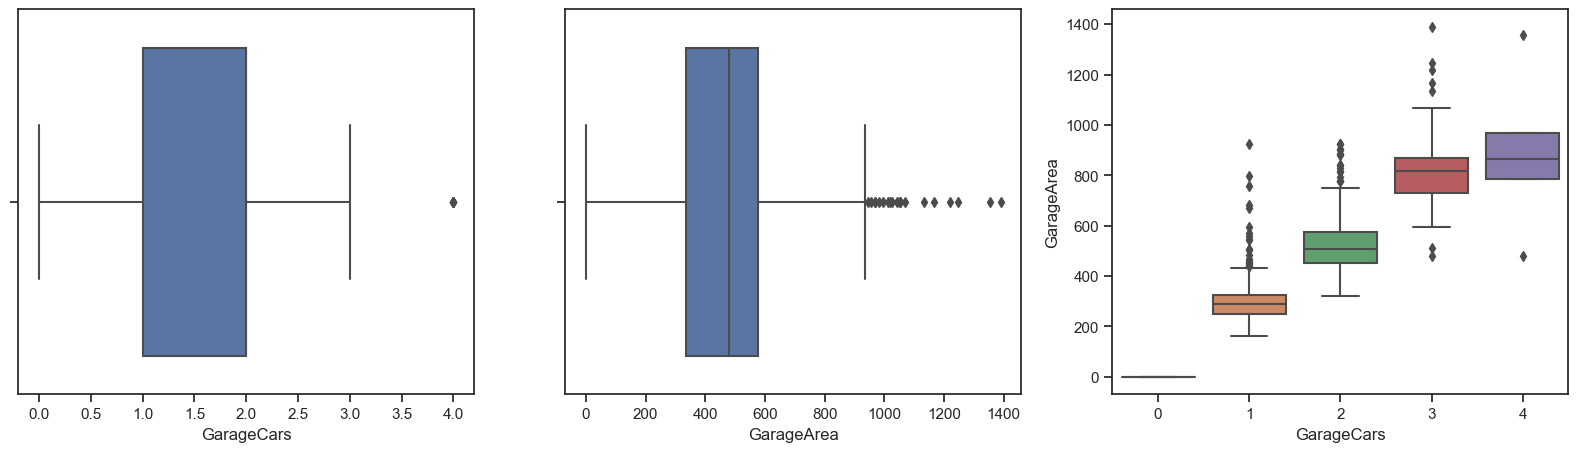

In [11]:
fig = plt.figure(figsize=(20,5))
fig1 = fig.add_subplot(131); sns.boxplot(x='GarageCars', data=train)
fig2 = fig.add_subplot(132); sns.boxplot(x='GarageArea', data=train)
fig3 = fig.add_subplot(133); sns.boxplot(x='GarageCars', y='GarageArea', data=train)
plt.show()

corr GarArea:  0.6306685489822315
corr GarCars:  0.6426836276074929
                                                            Outliers: 4


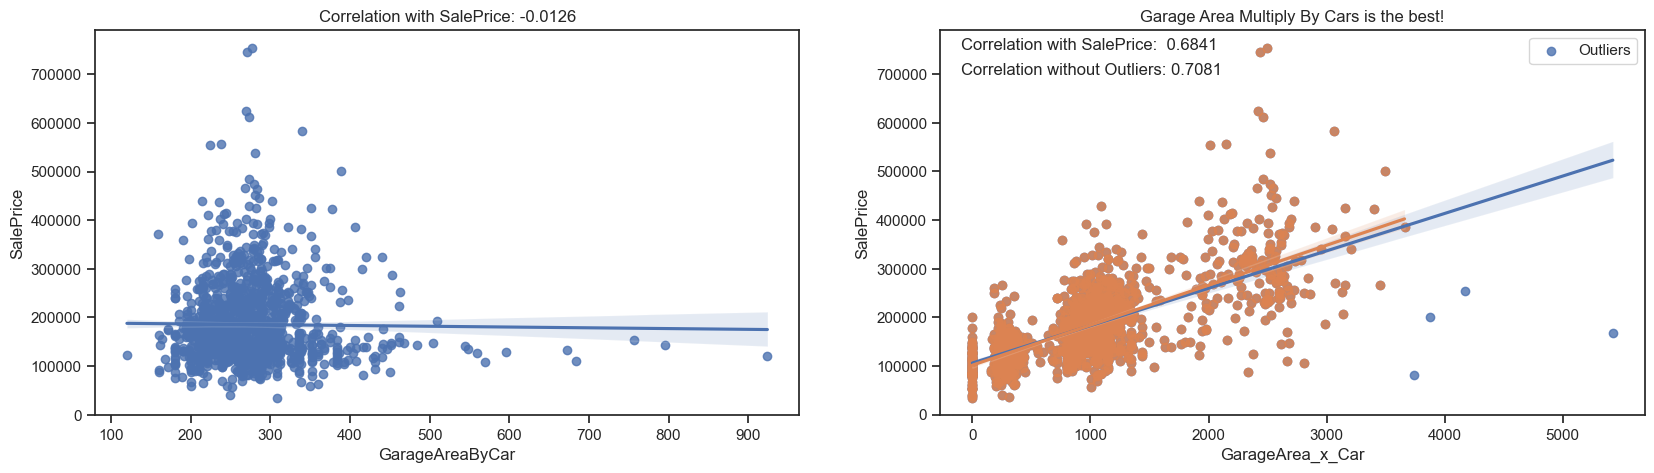

In [12]:
df = train[['SalePrice', 'GarageArea', 'GarageCars']].copy()
df['GarageAreaByCar'] = train.GarageArea/train.GarageCars
df['GarageArea_x_Car'] = train.GarageArea*train.GarageCars

corr_GarArea = df.GarageArea.corr(df.SalePrice)
corr_GarCars = df.GarageCars.corr(df.SalePrice)

print('corr GarArea: ', corr_GarArea)
print('corr GarCars: ', corr_GarCars)

fig = plt.figure(figsize=(20,5))
fig1 = fig.add_subplot(121); sns.regplot(x='GarageAreaByCar', y='SalePrice', data=df)
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.GarageAreaByCar.corr(df['SalePrice'])))

fig2 = fig.add_subplot(122); sns.regplot(x='GarageArea_x_Car', y='SalePrice', data=df); plt.legend(['Outliers'])
plt.text(x=-100, y=750000, s='Correlation with SalePrice:  {:6.4f}'.format(df.GarageArea_x_Car.corr(df['SalePrice'])))

outliers3 = (df.GarageArea_x_Car >= 3700)
print(' '*59, 'Outliers:',(outliers3).sum())
df = df.loc[~outliers3]
sns.regplot(x='GarageArea_x_Car', y='SalePrice', data=df); plt.title('Garage Area Multiply By Cars is the best!')
plt.text(x=-100, y=700000, s='Correlation without Outliers: {:6.4f}'.format(df.GarageArea_x_Car.corr(df['SalePrice'])))
plt.show()
del df

As can be seen the area by car is little useful, but contrary to common sense the multiplication of the area by the number of vacancies yes is. In the division we lose the magnitude and we have to maintain one or another functionality to recover it. With the multiplication we solve the problem of 1 parking space of 10 square feet against another of 10 with 1 square feet each. We could still ***improve the correlation*** by almost **0.06**, already considering the exclusion of only 4 outliers. 

The identification of the outliers was facilitated, note that before we would have a greater number of outliers, since the respective of each features alone are not coincident.
So let's continue with the multiplication strategy, remove the two original metrics that have high correlation with each other, and exclude the 4 outliers from the training base.

In [13]:
train = train[~outliers3]
print('Total observatiosn after outliers cut:', train.shape[0])

Total observatiosn after outliers cut: 1453


### Total Basement Area Vs 1st Floor Area
Let's see if Total Basement Area and 1st Floor Area can be integrated in a single variable and improve prediction.

corr 1stFlrSF:    0.6318
corr TotalBsmtSF: 0.6513
corr 1st vs Bsmt: 0.8030
                                                        Outliers: 1


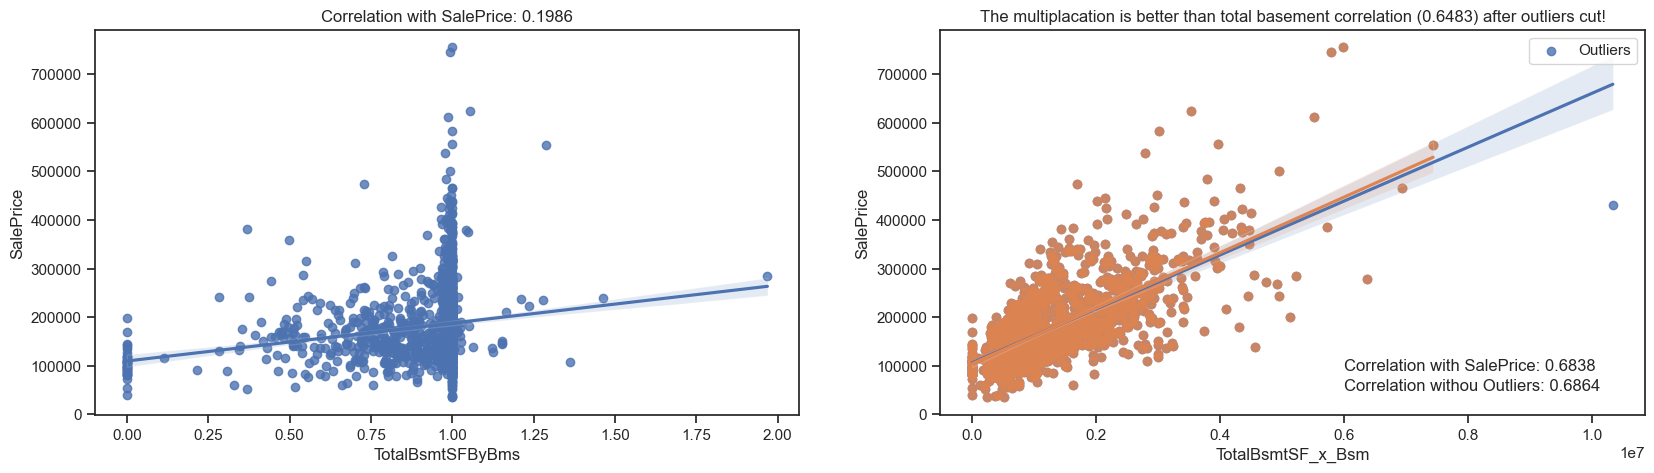

In [16]:
df = train[['SalePrice', 'TotalBsmtSF', '1stFlrSF']].copy()
df['TotalBsmtSFByBms'] = train.TotalBsmtSF/train['1stFlrSF']
df['TotalBsmtSF_x_Bsm'] = train.TotalBsmtSF*train['1stFlrSF']

corr_1st = train['1stFlrSF'].corr(train.SalePrice)
corr_Bsm = train['TotalBsmtSF'].corr(train.SalePrice)
corr_1st_vs_Bsm = train['1stFlrSF'].corr(train['TotalBsmtSF'])
                       
print('corr 1stFlrSF:    %1.4f' % corr_1st)
print('corr TotalBsmtSF: %1.4f' % corr_Bsm)
print('corr 1st vs Bsmt: %1.4f' % corr_1st_vs_Bsm)

fig = plt.figure(figsize=(20,5))
fig1 = fig.add_subplot(121); sns.regplot(x='TotalBsmtSFByBms', y='SalePrice', data=df);
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.TotalBsmtSFByBms.corr(df['SalePrice'])))
fig2 = fig.add_subplot(122); sns.regplot(x='TotalBsmtSF_x_Bsm', y='SalePrice', data=df); plt.legend(['Outliers'])
plt.text(x=6e06, y=90000, s='Correlation with SalePrice: {:1.4f}'.format(df.TotalBsmtSF_x_Bsm.corr(df['SalePrice'])))

print(' '*55, 'Outliers:',(df.TotalBsmtSF_x_Bsm>=0.9e07).sum())
df = df.loc[df.TotalBsmtSF_x_Bsm<0.9e07]
sns.regplot(x='TotalBsmtSF_x_Bsm', y='SalePrice', data=df); 
plt.title('The multiplacation is better than total basement correlation ({:1.4f}) after outliers cut!'.format(df.TotalBsmtSF.corr(df.SalePrice)))
plt.text(x=6e06, y=50000, s='Correlation withou Outliers: {:1.4f}'.format(df.TotalBsmtSF_x_Bsm.corr(df['SalePrice'])))
plt.show()
del df

Similar to what we saw in the garage analysis, we again have a better correlation by multiplying the variables, but now we don't have a significant gain with outliers exclusion. 

> So let's continue with the multiplication strategy and remove only the two original metrics that have high correlation with each other.

### Year Built Vs Garage Year Built
Of course, these two variables are highly correlated with each other. But what is the true impact of a later-built Garage?

corr YearBuilt vs GarageYrBlt: 0.8264


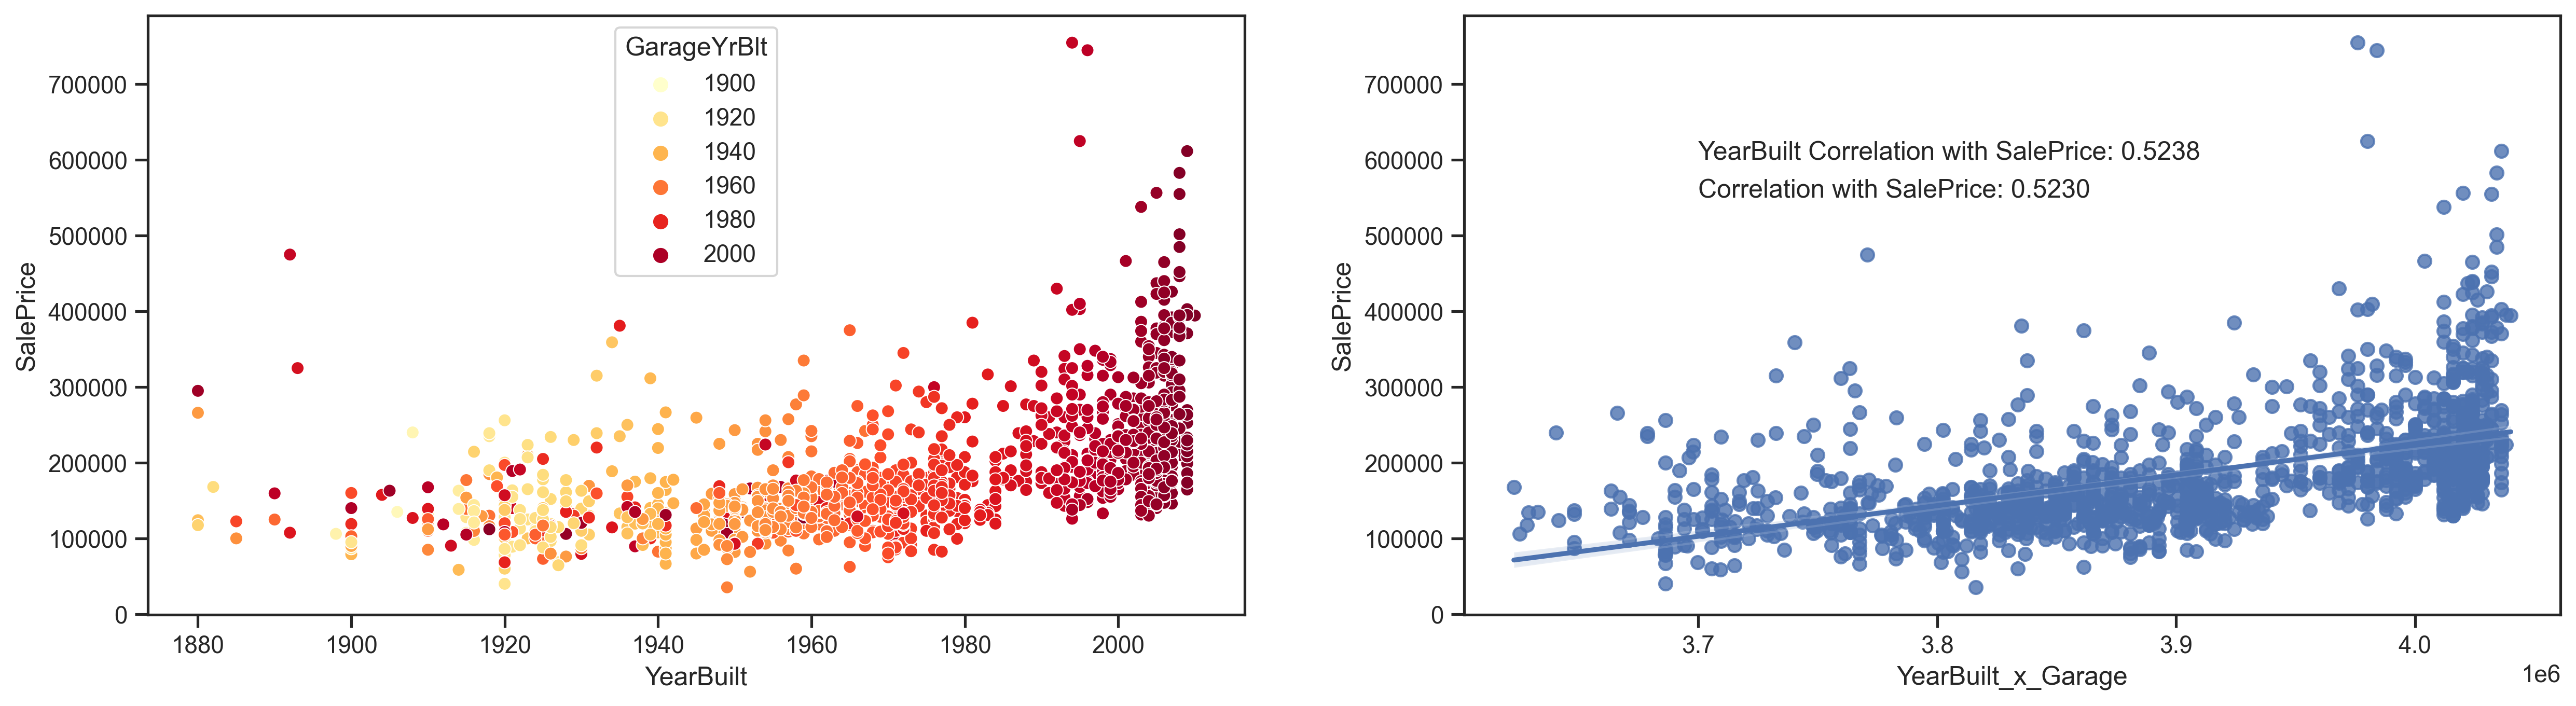

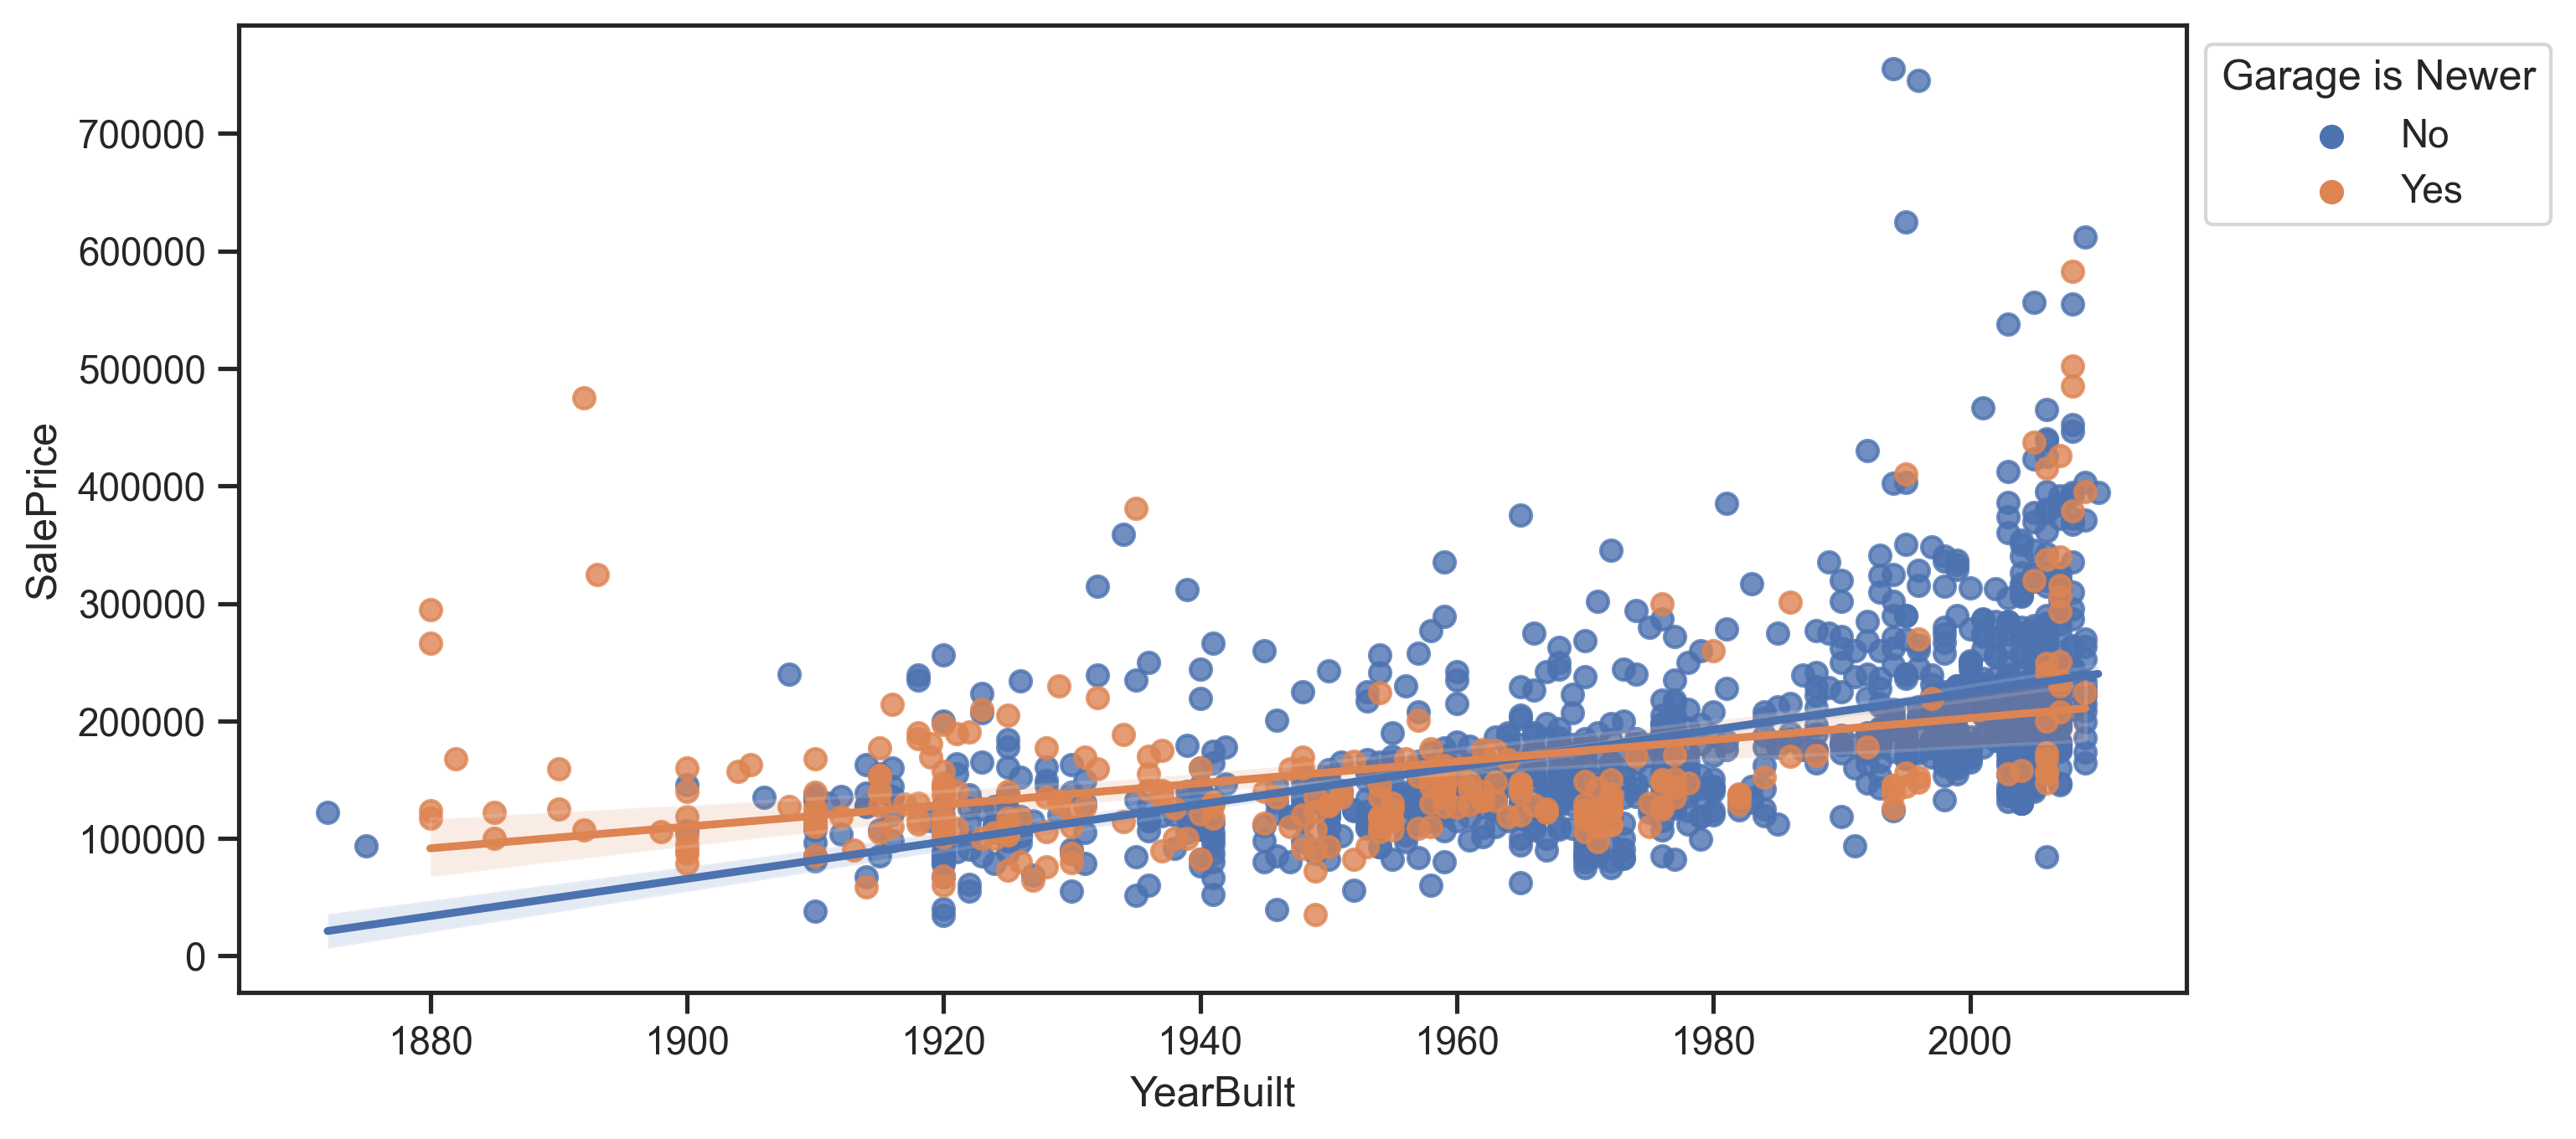

In [126]:
df = train[['SalePrice', 'YearBuilt', 'GarageYrBlt']].copy()
df['YearBuilt_x_Garage'] = train.YearBuilt*train.GarageYrBlt
df['GarageNewer'] = train.YearBuilt < train.GarageYrBlt

print('corr YearBuilt vs GarageYrBlt: %1.4f' % train['YearBuilt'].corr(train['GarageYrBlt']))

fig = plt.figure(figsize=(20,5))
fig1 = fig.add_subplot(121); sns.scatterplot(y = df.SalePrice, x = df.YearBuilt, hue=df.GarageYrBlt, palette= 'YlOrRd')
fig2 = fig.add_subplot(122); sns.regplot(x='YearBuilt_x_Garage', y='SalePrice', data=df); 
plt.text(x=3700000, y=600000, s='YearBuilt Correlation with SalePrice: {:1.4f}'.format(df.YearBuilt.corr(df['SalePrice'])))
plt.text(x=3700000, y=550000, s='Correlation with SalePrice: {:1.4f}'.format(df.YearBuilt_x_Garage.corr(df['SalePrice'])))
plt.show()

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
sns.regplot(y=df[~df.GarageNewer].SalePrice, x=df[~df.GarageNewer].YearBuilt, ax=ax)
sns.regplot(y=df[df.GarageNewer].SalePrice, x=df[df.GarageNewer].YearBuilt, ax=ax)
ax.legend(legend_labels, ['No', 'Yes'], title='Garage is Newer', 
          bbox_to_anchor=(1,1) )

plt.show()

del df

# Preprocessing and basic checks

In [55]:
# Split train/test
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

categorical_cols = [col for col in X_train_full.columns if 
            X_train_full[col].nunique() < 10 and
            X_train_full[col].dtype == 'object']

numerical_cols = [col for col in X_train_full.columns if
            X_train_full[col].dtype in ['int64', 'float64']]

my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

X_test  = X_test_full[my_cols].copy()

X_full_cols = X_full[my_cols].copy()

print('done.')

done.


In [56]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Model Selection (Random Forest)

In [63]:
def score_model(n_estimators, X_train, y_train, X_valid, y_valid):
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid) 
    return mean_absolute_error(y_valid, preds)

processed_X_train = preprocessor.fit_transform(X_train, y_train)
processed_X_valid = preprocessor.transform(X_valid)

scores_dict = {
    n: score_model(n, processed_X_train, y_train, processed_X_valid, y_valid)
        for n in range(700, 900, 10)
}

# best: 800 (mae 17413.38)
# best: 770 (mae 17400.31)

best_par =  min(scores_dict, key=scores_dict.get)
print('best: %d (mae %.2f)' % (best_par, scores_dict[best_par]))

best: 770 (mae 17400.31)


# Creating the final model (Random Forest)

In [30]:
best_par = 770
model_rf = RandomForestRegressor(n_estimators=best_par, random_state=0)

# Creating pipeline
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model_rf)
])

# fit
pipeline_rf.fit(X_full_cols, y)

# prediction
preds_test = pipeline_rf.predict(X_test)

print(preds_test)

[126787.4974026  154259.84155844 179258.25454545 ... 151787.61688312
 113134.28181818 228193.48571429]


In [29]:
# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(pipeline_rf, X_full, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print(pd.Series(scores).describe().loc[['min', 'max', 'mean']])

# Save test predictions to file
##output = pd.DataFrame({'Id': X_test.Id,
##                       'SalePrice': preds_test})
##output.to_csv(submission_path, index=False)

min     16343.690518
max     19097.668182
mean    17651.175382
dtype: float64


# Model Selection (XGBoost)
Here we will abuse of **X_valid** for *Early stopping rounds* to improve our
score function speed.

In [50]:
MODEL_STOPPING_ROUNDS=15

def score_model_xgb(n_estimators, lr, X_train, y_train, X_valid, y_valid):
    model = XGBRegressor(n_estimators=n_estimators, 
                         learning_rate=lr, 
                         early_stopping_rounds=MODEL_STOPPING_ROUNDS,
                         random_state=0)
    
    model.fit(X_train, y_train, verbose=False, eval_set=[(X_valid, y_valid)])
    preds = model.predict(X_valid) 
    return mean_absolute_error(y_valid, preds)

processed_X_train = preprocessor.fit_transform(X_train, y_train)
processed_X_valid = preprocessor.transform(X_valid)

scores_dict005 = {
    n: score_model_xgb(n, 0.05, processed_X_train, y_train, processed_X_valid, y_valid)
        for n in range(100, 450, 50)
}

scores_dict01 = {
    n: score_model_xgb(n, 0.1, processed_X_train, y_train, processed_X_valid, y_valid)
        for n in range(100, 450, 50)
}

best_par =  min(scores_dict005, key=scores_dict005.get)
print('best lr=0.05: %d (mae %.2f)' % (best_par, scores_dict005[best_par]))

best_par =  min(scores_dict01, key=scores_dict01.get)
print('best lr=0.1: %d (mae %.2f)' % (best_par, scores_dict01[best_par]))

best lr=0.05: 250 (mae 16668.71)
best lr=0.1: 150 (mae 16809.38)


# Creating the final model (XGBoost)

In [46]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [52]:
# Model
model_xgb = XGBRegressor(n_estimators=250, 
                         learning_rate=0.05)

model_params = {
        'model__verbose': False,
}

# Bundle preprocessing and modeling code in a pipeline
pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model_xgb)])


# Preprocessing of training data, fit model 
pipeline_xgb.fit(X_full_cols, y, **model_params)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='constant'),
                                                  ['Id', 'MSSubClass',
                                                   'LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQualFinSF',
                                                   'GrLivArea', 'BsmtFullBath',
                                                   'BsmtHalfBath', 'F...
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.05, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=6, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=250, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, ...))])

In [53]:
# Preprocessing of validation data, get predictions
preds = pipeline_xgb.predict(X_full_cols)

# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(pipeline_xgb, X_full_cols, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

In [54]:
pd.Series(scores).describe()[['min', 'max', 'mean']]

min     15428.557390
max     18403.125990
mean    16637.748454
dtype: float64